<a href="https://colab.research.google.com/github/EduardoIllanes/Reconstruccion-e-Interpolacion-de-Audio/blob/main/Tensorflow_Siren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstrucción de audio

In [25]:
!pip install librosa &> /dev/null

In [26]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import numpy as np
import scipy.io.wavfile as wavfile
import io
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt

Creamos la arquitectura de nuestra SIRENs

In [27]:
class SineLayer(Layer):
  def __init__(self, out_features, is_first = False, bias = True, omega_0 = 30):
    super().__init__()
    self.out_features = out_features
    self.omega_0 = omega_0
    self.is_first = is_first
  
  def build(self, input_shape):
    if self.is_first:
      self.linear = Dense(self.out_features,
                        input_shape = input_shape,
                        kernel_initializer = tf.keras.initializers.RandomUniform(minval= -1 / input_shape[-1], 
                                                                                 maxval= 1 / input_shape[-1]))
    else:
      self.linear = Dense(self.out_features,
                        input_shape = input_shape,
                        kernel_initializer = tf.keras.initializers.RandomUniform(minval= -np.sqrt(6 / input_shape[-1]) / self.omega_0, 
                                                                                 maxval= np.sqrt(6 / input_shape[-1]) / self.omega_0))
  
  def call(self, x):
    return tf.math.sin(self.omega_0 * self.linear(x))

In [28]:
class Siren(Layer):
  def __init__(self, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
    super().__init__()
    self.hidden_layers = hidden_layers
    self.hidden_features = hidden_features
    self.first_omega_0 = first_omega_0
    self.hidden_omega_0 = hidden_omega_0
    self.out_features = out_features
    self.net = Sequential()
    self.outermost_linear = outermost_linear

  def build(self, input_shape):
    self.net.add(SineLayer(self.hidden_features, 
                                  is_first=True, omega_0=self.first_omega_0))
    for i in range(self.hidden_layers):
      self.net.add(SineLayer(self.hidden_features, 
                                      is_first=False, omega_0=self.hidden_omega_0))
    if self.outermost_linear:
      self.net.add(Dense(self.out_features,
                        input_shape = input_shape,
                        kernel_initializer = tf.keras.initializers.RandomUniform(minval= -np.sqrt(6 / input_shape[-1]) / self.hidden_omega_0, 
                                                                                 maxval= np.sqrt(6 / input_shape[-1]) / self.hidden_omega_0)))
    else:
      self.net.add(SineLayer(self.out_features, 
                                      is_first=False, omega_0=self.hidden_omega_0))
  def call(self, x):
    x = self.net(x)
    return x


Obtenemos las canciones
**Nota:** La otra cacnción se encuentra en el github

In [29]:
!wget https://vsitzmann.github.io/siren/img/audio/gt_bach.wav

--2021-09-30 21:57:07--  https://vsitzmann.github.io/siren/img/audio/gt_bach.wav
Resolving vsitzmann.github.io (vsitzmann.github.io)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to vsitzmann.github.io (vsitzmann.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: ‘gt_bach.wav.2’

gt_bach.wav.2       100%[===================>]   1.17M  --.-KB/s    in 0.07s   

2021-09-30 21:57:08 (17.0 MB/s) - ‘gt_bach.wav.2’ saved [1232886/1232886]



Procesamos los audios

(154104, 1) (154104, 1)


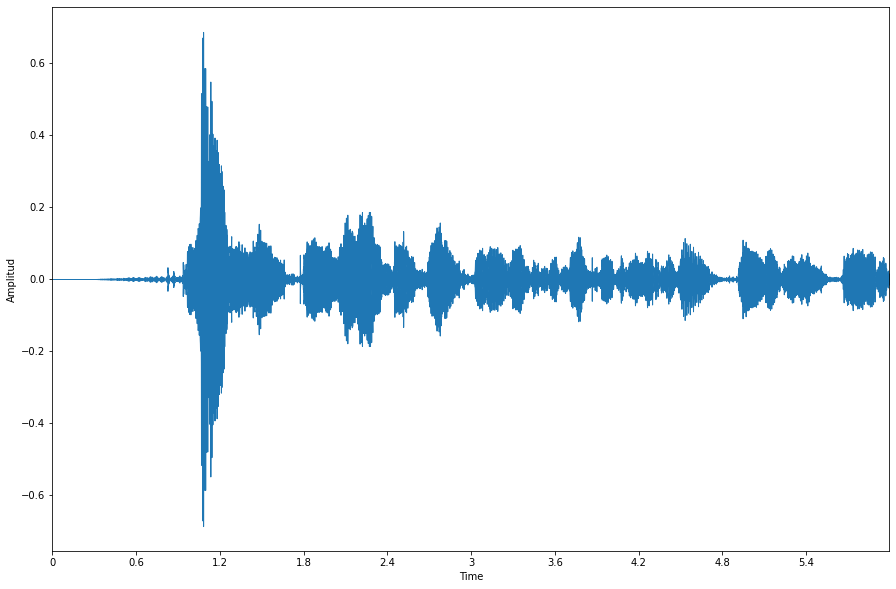

In [30]:
import librosa.display
audio, _ = librosa.load('hablando.wav')
plt.figure(figsize=(15,10))
librosa.display.waveplot(audio, 22050)
plt.ylabel("Amplitud") # El eje x es Time por defecto
audio = np.expand_dims(audio, -1)
audio_1, _ = librosa.load('gt_bach.wav')
audio_1 = np.expand_dims(audio_1, -1)
audio = np.resize(audio, audio_1.shape)
print(audio.shape, audio_1.shape)

Creamos nuestro modelo

In [31]:
def create_model():
  input = Input(shape=(1,))
  siren = Siren(256,3, 1, first_omega_0=30000, outermost_linear=True) #El omega se cambia para poder escalar la amplitud de los audios
  x = siren(input)
  model = Model(inputs = input, outputs = x)
  return model

In [32]:
model = create_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
siren_1 (Siren)              (None, 1)                 198145    
Total params: 198,145
Trainable params: 198,145
Non-trainable params: 0
_________________________________________________________________


In [33]:
optimizer = tf.optimizers.Adam(learning_rate=1e-4)

In [34]:
def train_step(inputs, model, optimizer):
    with tf.GradientTape() as tape:
      prediction = model(inputs)
      mse = tf.keras.losses.MeanSquaredError()
      loss = mse(inputs, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

Entrenamos

In [35]:
total_steps = 1000 
steps_til_summary = 100
for step in range(total_steps):
  loss = train_step(audio, model, optimizer)
  if not step % steps_til_summary:
      print("Step %d, Total loss %0.6f" % (step, loss))

Step 0, Total loss 0.229797
Step 100, Total loss 0.034985
Step 200, Total loss 0.039390
Step 300, Total loss 0.002290
Step 400, Total loss 0.000908
Step 500, Total loss 0.000606
Step 600, Total loss 0.000450
Step 700, Total loss 0.000350
Step 800, Total loss 0.000277
Step 900, Total loss 0.000223


Audio Original

In [36]:
Audio('hablando.wav')

Audio reconstruido

In [37]:
final_output = model(audio)
final_output = tf.squeeze(final_output)
Audio(final_output.numpy(), rate=22050)

# Modelo ReLU

In [38]:
input_x = Input(shape=(1,))
out = Dense(256, activation='relu')(input_x)
out = Dense(256, activation='relu')(out)
out = Dense(1)(out)
model_relu = Model(inputs = input_x, outputs = out)
model_relu.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________


In [39]:
total_steps = 1000 
steps_til_summary = 100
for step in range(total_steps):
  loss = train_step(audio, model_relu, optimizer)
  if not step % steps_til_summary:
      print("Step %d, Total loss %0.6f" % (step, loss))

Step 0, Total loss 0.001314
Step 100, Total loss 0.000002
Step 200, Total loss 0.000000
Step 300, Total loss 0.000000
Step 400, Total loss 0.000000
Step 500, Total loss 0.000000
Step 600, Total loss 0.000000
Step 700, Total loss 0.000000
Step 800, Total loss 0.000000
Step 900, Total loss 0.000000


In [40]:
final_output_1 = model_relu(audio)
final_output_1 = tf.squeeze(final_output_1)
Audio(final_output_1.numpy(), rate=22050)

Text(0.5, 1.0, 'ReLU')

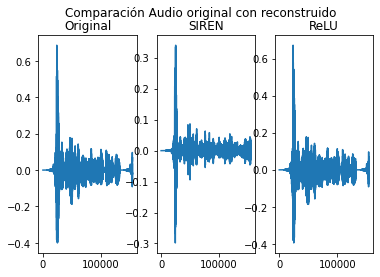

In [53]:
fig, axs = plt.subplots(1,3)
fig.suptitle('Comparación Audio original con reconstruido')
axs[0].plot(audio.squeeze(-1))
axs[0].set_title('Original')
axs[1].plot(final_output)
axs[1].set_title('SIREN')
axs[2].plot(final_output_1)
axs[2].set_title('ReLU')

# Interpolación

Sacamos los gradientes de cada canción y los fusionamos de acuerdo a la siguiente formula

In [42]:
grad = np.gradient(audio, axis = 0)
grad_1 = np.gradient(audio_1, axis = 0)
grads = grad + grad_1*(1-0.8) #0.8 Corresponde a un hiperparametro

In [43]:
total_steps = 1000 
steps_til_summary = 100
for step in range(total_steps):
  loss = train_step(grads, model, optimizer)
  if not step % steps_til_summary:
      print("Step %d, Total loss %0.6f" % (step, loss))

Step 0, Total loss 0.000086
Step 100, Total loss 0.000035
Step 200, Total loss 0.000025
Step 300, Total loss 0.000019
Step 400, Total loss 0.000015
Step 500, Total loss 0.000011
Step 600, Total loss 0.000009
Step 700, Total loss 0.000007
Step 800, Total loss 0.000008
Step 900, Total loss 0.000005


Audio interpolado

In [44]:
final_output = model(grads)
final_output = tf.squeeze(final_output)
Audio(final_output.numpy(), rate=22050)

ReLU

In [45]:
total_steps = 1000 
steps_til_summary = 100
for step in range(total_steps):
  loss = train_step(grads, model_relu, optimizer)
  if not step % steps_til_summary:
      print("Step %d, Total loss %0.6f" % (step, loss))

Step 0, Total loss 0.000000
Step 100, Total loss 0.000000
Step 200, Total loss 0.000000
Step 300, Total loss 0.000000
Step 400, Total loss 0.000000
Step 500, Total loss 0.000000
Step 600, Total loss 0.000000
Step 700, Total loss 0.000000
Step 800, Total loss 0.000000
Step 900, Total loss 0.000000


In [46]:
final_output = model_relu(grads)
final_output = tf.squeeze(final_output)
Audio(final_output.numpy(), rate=22050)